In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split

import pickle

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('device:', device)

device: cuda


In [ ]:
from IPython.display import HTML, display


# Custom IPython progress bar for training
class ProgressMonitor(object):
    
    tmpl = """
        <table style="width: 100%;">
            <tbody>
                <tr>
                    <td style="width: 30%;">
                     <b>Loss: {loss:0.4f}</b> &nbsp&nbsp&nbsp {value} / {length}
                    </td>
                    <td style="width: 70%;">
                        <progress value='{value}' max='{length}', style='width: 100%'>{value}</progress>
                    </td>
                </tr>
            </tbody>
        </table>        
        """

    def __init__(self, length):
        self.length = length
        self.count = 0
        self.display = display(self.html(0, 0), display_id=True)
        
    def html(self, count, loss):
        return HTML(self.tmpl.format(length=self.length, value=count, loss=loss))
        
    def update(self, count, loss):
        self.count += count
        self.display.update(self.html(self.count, loss))

In [ ]:
#데이터 불러오기
from torchvision.transforms import transforms as T
from torch.utils.data import DataLoader

from matplotlib.pyplot import imshow
%matplotlib inline


sz = 128

trans= T.Compose([T.Resize([sz, sz]), T.ToTensor(), T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
train_data=torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/projectdata/Traindata/train', transform=trans)
test_data=torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/projectdata/Traindata/test', transform=trans)


trainloader = DataLoader(train_data, batch_size=1, shuffle=True, num_workers=2)

print(len(trainloader))
print(train_data[0][0].shape)
n_classes=len(train_data.classes)
torch.Size([3,sz,sz])

1468
torch.Size([3, 128, 128])


torch.Size([3, 128, 128])

In [ ]:
classes=train_data.classes
classes

['label0', 'label1']

In [ ]:
# CNN의 구조변경

class Resnet(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.conv_layers1 = nn.Sequential(


            nn.Conv2d( in_channels=3, out_channels=64, kernel_size=3, padding=1 ),                    
            nn.BatchNorm2d(64),
            nn.ReLU(),    

            nn.Conv2d( in_channels=64, out_channels=128, kernel_size=3, padding=1 ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            

 
        )

        self.res1=nn.Sequential(
            nn.Conv2d( in_channels=128, out_channels=128, kernel_size=3, padding=1 ),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d( in_channels=128, out_channels=128, kernel_size=3, padding=1 ),
            nn.BatchNorm2d(128),
            nn.ReLU(),


        )

        self.conv_layers2= nn.Sequential(
            nn.Conv2d( in_channels=128, out_channels=256, kernel_size=3, padding=1 ),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d( in_channels=256, out_channels=512, kernel_size=3, padding=1 ),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.res2=nn.Sequential(
            nn.Conv2d( in_channels=512, out_channels=512, kernel_size=3, padding=1 ),
            nn.BatchNorm2d(512),
            nn.ReLU(),

        )

        self.conv_layers3= nn.Sequential(
            nn.Conv2d( in_channels=512, out_channels=1024, kernel_size=3, padding=1 ),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)

        )

        self.res3=nn.Sequential(
            nn.Conv2d( in_channels=1024, out_channels=1024, kernel_size=3, padding=1 ),
            nn.BatchNorm2d(1024),
            nn.ReLU(),

        )

        self.fc_layers = nn.Sequential(


            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(1024 * sz//32 * sz//32 , 3),


        )
        
        
    def forward(self, x):

        x = self.conv_layers1(x) 

        x = self.res1(x) + x  

        x = self.conv_layers2(x)    

        x = self.res2(x) + x

        x = self.conv_layers3(x)

        x = self.res3(x) + x   
        

        x = self.fc_layers(x)

        return x

In [ ]:
train_data[0][0].size()

torch.Size([3, 128, 128])

In [ ]:
temp = Resnet()
output = torch.randn( 7, 3, sz, sz)

print( temp(output).size() )


torch.Size([7, 3])


In [ ]:
#하이퍼 파라미터 조정
batch_size = 64
learning_rate = 0.00001 
num_epochs = 10

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
model = Resnet()

model.to(device)

Resnet(
  (conv_layers1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (conv_layers2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Batch

In [ ]:
# optimizer 방식을 변경 원하는 경우 변경 가능

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

lr_scheduler_ft = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.2)

In [ ]:
#학습과정
from statistics import mean 

def train(optimizer, model, num_epochs=10, first_epoch=1):
    
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    test_losses = []
    

    for epoch in range(first_epoch, first_epoch + num_epochs):
        print('Epoch', epoch)

        train_total=0
        test_total=0

        # train phase
        model.train()

        # create a progress bar
        progress = ProgressMonitor(length=len(train_data))
        
        # keep track of predictions
        correct_train = 0

        batch_losses = []

        for batch, targets in train_loader:
            
            # Move the training data to the GPU
            batch = batch.to(device)
            targets = targets.to(device)

            # clear previous gradient computation
            optimizer.zero_grad()

            # forward propagation
            outputs = model(batch)

            # calculate the loss
            loss = criterion(outputs, targets)

            # backpropagate to compute gradients
            loss.backward()

            # update model weights
            optimizer.step()

            batch_losses.append(loss.item())

            # accumulate correct count
            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == targets.data)

            # update progress bar
            progress.update(batch.shape[0], mean(batch_losses) )
            
            train_total+=outputs.size(0)
            
        
        train_losses.append( mean(batch_losses))


        # test phase
        model.eval()

        y_pred = []

        correct_test = 0

        # We don't need gradients for test, so wrap in 
        # no_grad to save memory
        with torch.no_grad():

            for batch, targets in test_loader:

                # Move the training batch to the GPU
                batch = batch.to(device)
                targets = targets.to(device)

                # forward propagation
                outputs = model(batch)

                # calculate the loss
                loss = criterion(outputs, targets)

                # save predictions
                y_pred.extend( outputs.argmax(dim=1).cpu().numpy() )

                # accumulate correct count
                _, preds = torch.max(outputs, 1)
                correct_test += torch.sum(preds == targets.data)

                test_total+=outputs.size(0)
                

        # Calculate accuracy
        train_acc = correct_train.item() / train_total
        test_acc = correct_test.item() / test_total

        print('Training accuracy: {:.2f}%'.format(float(train_acc) * 100))
        print('Test accuracy: {:.2f}%\n'.format(float(test_acc) * 100))

    
    return train_losses, test_losses, y_pred

In [ ]:
#@학습 시작
train_losses, test_losses, y_pred = train(optimizer, model, num_epochs=num_epochs)

Epoch 1


Loss: 0.5337 1468 / 1468,1468


Training accuracy: 72.62%
Test accuracy: 63.59%

Epoch 2


Loss: 0.5083 1468 / 1468,1468


Training accuracy: 74.18%
Test accuracy: 64.10%

Epoch 3


Loss: 0.4993 1468 / 1468,1468


Training accuracy: 75.14%
Test accuracy: 63.33%

Epoch 4


Loss: 0.4982 1468 / 1468,1468


Training accuracy: 75.95%
Test accuracy: 63.08%

Epoch 5


Loss: 0.4949 1468 / 1468,1468


Training accuracy: 76.23%
Test accuracy: 65.64%

Epoch 6


Loss: 0.4944 1468 / 1468,1468


Training accuracy: 75.68%
Test accuracy: 64.36%

Epoch 7


Loss: 0.4883 1468 / 1468,1468


Training accuracy: 76.36%
Test accuracy: 64.36%

Epoch 8


Loss: 0.4821 1468 / 1468,1468


Training accuracy: 76.57%
Test accuracy: 64.87%

Epoch 9


Loss: 0.4763 1468 / 1468,1468


Training accuracy: 77.59%
Test accuracy: 64.10%

Epoch 10


Loss: 0.4810 1468 / 1468,1468


Training accuracy: 76.16%
Test accuracy: 64.87%



In [ ]:
# 저장
torch.save(model,'Chim_model_ver1.pt')

In [ ]:
from PIL import Image
from io import BytesIO


In [ ]:
def transform_image(image_bytes):
    my_transforms = T.Compose([T.Resize([sz,sz]),
                                        
                                        T.ToTensor(),
                                        T.Normalize(
                                            [0.5, 0.5, 0.5],
                                            [0.5, 0.5, 0.5])])
    image = Image.open(BytesIO(image_bytes))
    return my_transforms(image).unsqueeze(0)

0  at confidence score:0.63


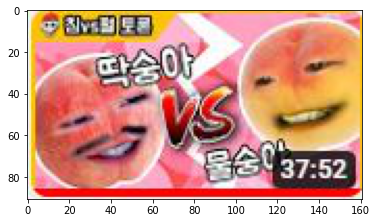

In [ ]:
#새로운 사진 분류
model = torch.load('/content/Chim_model_ver1.pt')
model.eval()
 
def get_prediction(image_bytes):
    tensor = transform_image(image_bytes=image_bytes)
    tensor=tensor.to(device)
    output = model.forward(tensor)
     
    probs = torch.nn.functional.softmax(output, dim=1)
    conf, classes = torch.max(probs, 1)
    return conf.item(), classes.item()
 
image_path="/content/aa.JPG"
image = plt.imread(image_path)
plt.imshow(image)
 
with open(image_path, 'rb') as f:
    image_bytes = f.read()
 
    conf,y_pre=get_prediction(image_bytes=image_bytes)
    print(y_pre, ' at confidence score:{0:.2f}'.format(conf))